# Data Science Pipeline

1. Data processing
   - in Yuhao's another jupyter notebook
2. Data exploration
    - distribution of categorical/discrete numeric data
    - distribution of continuous numeric data
    - data cleaning
3. Feature engineering
4. Machine learning modles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from scipy.special import boxcox1p
from sklearn.model_selection import learning_curve
from sklearn import preprocessing
import math
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data Exploration

In [2]:
init_df = pd.read_csv('merged_data.csv')
init_df.head()

,num_baths,num_beds,latitude,longitude,zip_code,property_class,sale_trans_date,sale_amount,universal_size,year_built,...,Twitter,Uber,Wikimedia,Workday,Yahoo,Yelp,YouTube,Zendesk,Zoosk,Facebook
0,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-01-04,970000,1299,1993,...,0.000383,0.004867,0.000023,0.014384,0.016568,0.000515,0.012777,0.000176,0.000012,0.040131
1,1.0,1,37.797958,-122.399894,94111,Condominium (residential),2016-01-29,1300000,1189,2007,...,0.000302,0.003901,0.000030,0.013412,0.015701,0.000373,0.012242,0.000139,0.000010,0.037327
2,2.0,0,37.803797,-122.404136,94111,Condominium (residential),2016-03-08,1475000,1423,1983,...,0.000223,0.002633,0.000032,0.014539,0.016705,0.000656,0.011540,0.000150,0.000011,0.040577
3,2.0,0,37.803797,-122.404136,94111,Condominium (residential),2016-03-21,1400000,1518,1983,...,0.000118,0.001119,0.000050,0.014163,0.016370,0.000855,0.009462,0.000143,0.000011,0.039492
4,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-03-03,955000,1033,1993,...,0.000894,0.010659,0.000153,0.016205,0.018190,0.002560,0.014889,0.000621,0.000047,0.045383


In [3]:
init_df.dtypes

num_baths          float64
num_beds             int64
latitude           float64
longitude          float64
zip_code             int64
property_class      object
sale_trans_date     object
sale_amount          int64
universal_size       int64
year_built           int64
age_year             int64
price              float64
duplex               int64
apartment            int64
condo                int64
townhouse            int64
num_schools          int64
district            object
num_crimes           int64
Airbnb             float64
Ask                float64
Cisco              float64
Craigslist         float64
Ebates             float64
eBay               float64
Googleplex         float64
Hearsay            float64
LinkedIn           float64
Lyft               float64
Pinterest          float64
Quora              float64
Salesforce         float64
SurveyMonkey       float64
Twitter            float64
Uber               float64
Wikimedia          float64
Workday            float64
Y

### Data Distribution

In [4]:
# discrete numeric columns/categorical columns
cat_cols = ['num_baths', 'num_beds', 'zip_code', 'property_class', 'sale_trans_date',
            'age_year', 'year_built', 'duplex', 'apartment', 'condo', 'townhouse', 'num_schools',
           'num_crimes', 'district']
# continuous numeric columns
numeric_cols = list(set(init_df.columns).difference(set(cat_cols)))
print(numeric_cols)

['Pinterest', 'eBay', 'SurveyMonkey', 'LinkedIn', 'Yahoo', 'Twitter', 'Ebates', 'Airbnb', 'Lyft', 'Yelp', 'Wikimedia', 'sale_amount', 'Googleplex', 'Cisco', 'Workday', 'latitude', 'Facebook', 'Craigslist', 'Zoosk', 'Quora', 'universal_size', 'longitude', 'Hearsay', 'YouTube', 'Uber', 'price', 'Ask', 'Zendesk', 'Salesforce']


### Categorical / discrete numeric columns

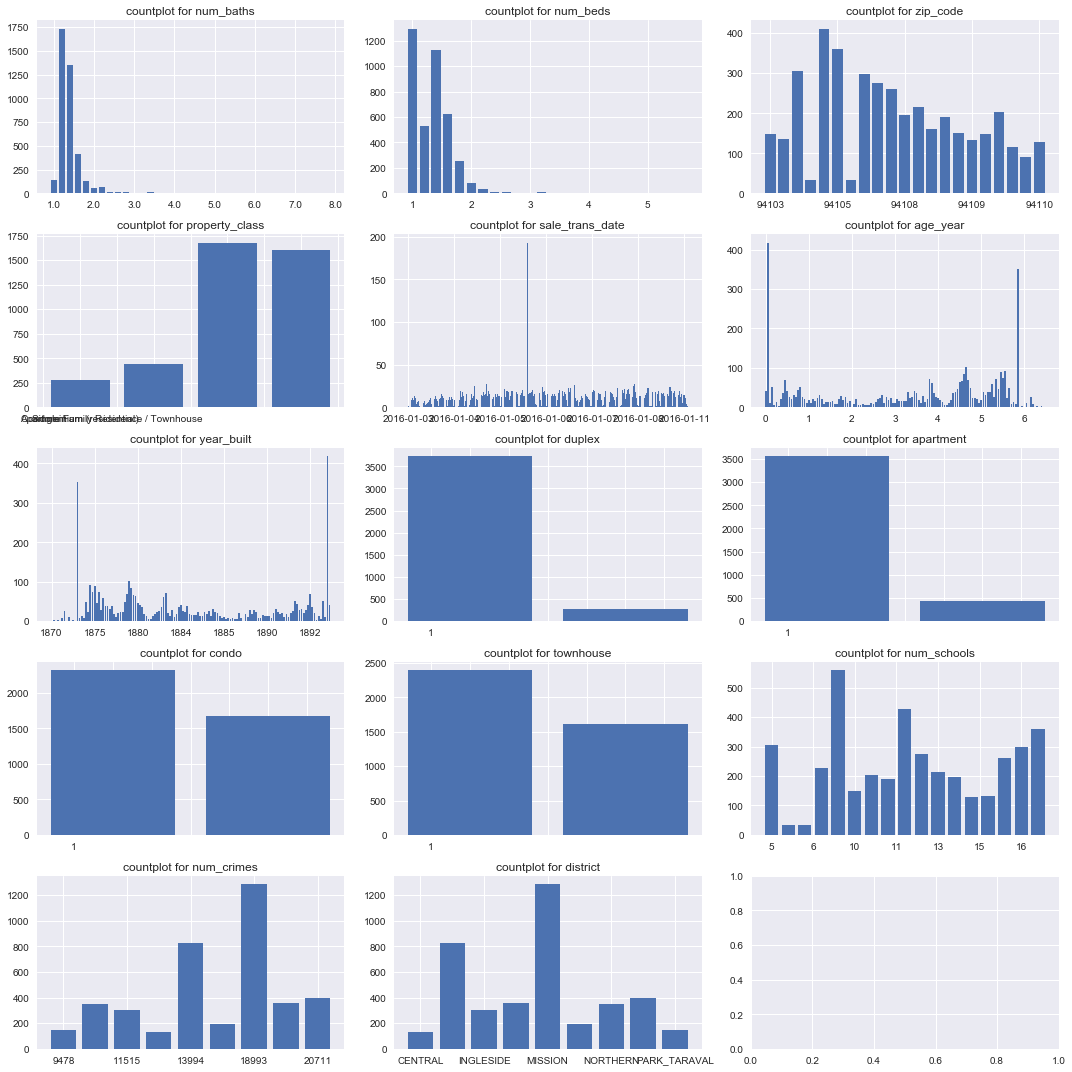

In [5]:
# plot categorical/discrete numeric cols
num_cat = len(cat_cols)
ncols = 3
nrows = math.ceil(num_cat/ncols)
cat_fig, cat_axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        ax = cat_axes[row][col]
        idx = ncols * row + col
        if idx < num_cat:
            counts = init_df[cat_cols[idx]].value_counts().sort_index()
            ind = np.arange(len(counts))
            ax.bar(ind, counts.values)
            ax.set_xticklabels(counts.index.values)
            ax.set_title('countplot for {}'.format(cat_cols[idx]))
plt.tight_layout()

#### Findings from the countplots above. Analysis see below

Q1. age_year might have values of 0?  
Q2. age_year and year_built are duplicates?  
Q3. a property can be duplex, apartment, condo... at the same time?  
Q4: correlation between num_baths & num_beds?

**Q1**

In [6]:
# age_year
init_df.age_year.value_counts().sort_index().head()

-1     42
 0    418
 1     10
 2     51
 3      6
Name: age_year, dtype: int64

In [7]:
# why age_year = -1?
init_df[init_df['age_year']==-1].year_built.values

array([2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
       2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
       2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
       2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017], dtype=int64)

**=> Answer to Q1: Consider to remove the properties built in 2017**

**Q2**

In [8]:
year_df = init_df[['age_year', 'year_built']]
year_df['calc_age'] = 2016 - year_df['year_built']
year_df['same'] = np.where(year_df['age_year']==year_df['calc_age'], 1, 0)
year_df['same'].value_counts()

1    3997
Name: same, dtype: int64

**=> Answer to Q2:**  
 - **verified: age_year = (2017 - year_built)**    
 - **consider to remove year_built and keep age_year only**

**Q3**

In [9]:
class_df = init_df[['duplex', 'apartment', 'condo', 'townhouse']]
class_df['sum'] = class_df['duplex'] + class_df['apartment'] + class_df['condo'] + class_df['townhouse']
class_df['sum'].value_counts()

1    3997
Name: sum, dtype: int64

**=> Answer to Q3: a property is either duplex or apartment or condo or townhouse**

**Q4**

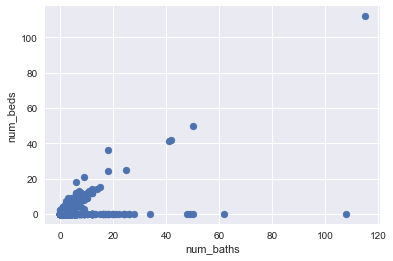

In [10]:
plt.scatter(x=init_df['num_baths'], y=init_df['num_beds'])
plt.xlabel('num_baths')
plt.ylabel('num_beds')

**=> Answer to Q4: no significant correlation between num_baths and num_beds**

### Continuous numeric columns

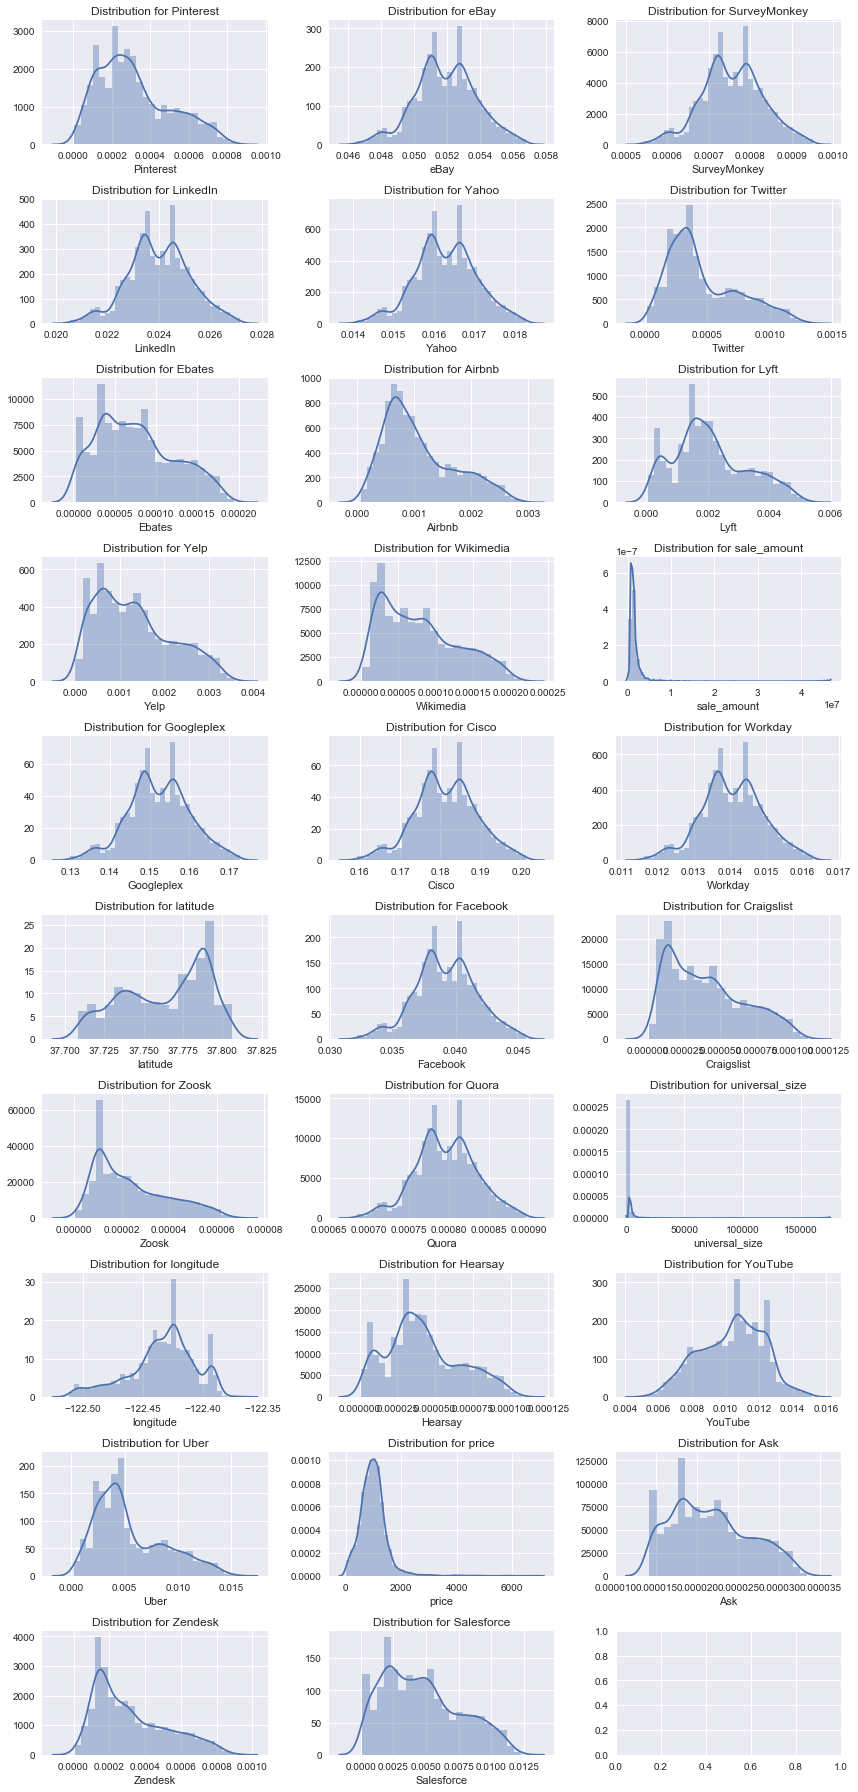

In [11]:
def draw_numeric_plot(init_df, numeric_col,figsize):
    num_numeric = len(numeric_cols)
    ncols = 3
    nrows = math.ceil(num_numeric/ncols)
    numeric_fig, numeric_axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    for row in range(nrows):
        for col in range(ncols):
            ax = numeric_axes[row][col]
            idx = ncols * row + col
            if idx < num_numeric:
                g=sns.distplot(init_df[numeric_cols[idx]], kde=True, label='skewness:%.2f' %
                     init_df[numeric_cols[idx]].skew(), ax = numeric_axes[row][col])
                plt.legend(loc='best', fontsize='large')
    #             ax.hist(init_df[numeric_cols[idx]])
                ax.set_title('Distribution for {}'.format(numeric_cols[idx]))
    plt.tight_layout()

draw_numeric_plot(init_df,numeric_cols,(12,25))

#### Findings from the histograms above. Analysis see below

Q1: price * universal_size = sale_amount?  
Q2: correlation between price & sale_amount, and universal_size & sale_amount?  
Q3: correlation between price & sum distance to all companies?

**Q1**

In [12]:
price_df = init_df[['price', 'universal_size', 'sale_amount']]
price_df['calc_amount'] = price_df['price'] * price_df['universal_size']
# if gap > $10, considered different
price_df['gap_is_small'] = np.where(abs(price_df['calc_amount'] - price_df['sale_amount'])>10, 0, 1)
price_df['gap_is_small'].value_counts()

1    3997
Name: gap_is_small, dtype: int64

**=> Answer to Q1: (price * universal_size) roughly equals to sale_amount, so consider to remove sale_amount**

**Q2**

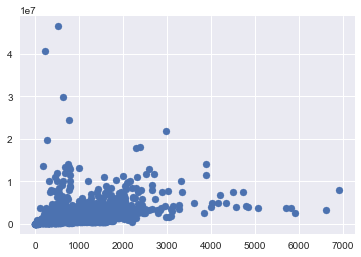

In [13]:
plt.scatter(x=price_df['price'], y=price_df['sale_amount'])

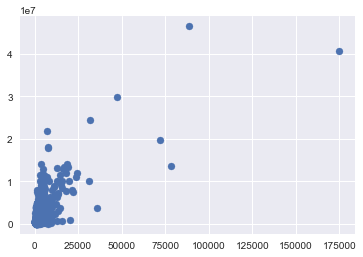

In [14]:
plt.scatter(x=price_df['universal_size'], y=price_df['sale_amount'])

**=> Answer to Q2: no significant correlation between price & sale_amount or universal_size & sale_amount**

**Q3**

In [15]:
company_names = set(numeric_cols).difference(set(['latitude', 'longitude', 'price', 
                                                  'universal_size', 'sale_amount']))
sum_dist = pd.Series(np.zeros(init_df.shape[0]))
for name in company_names:
    sum_dist += init_df[name]

dist_price_df = pd.concat([price_df, sum_dist], axis=1).rename(columns={0:"sum_dist"})
dist_price_df.head()

,price,universal_size,sale_amount,calc_amount,gap_is_small,sum_dist
0,746.728253,1299,970000,970000.0,1,0.511812
1,1093.355761,1189,1300000,1300000.0,1,0.482447
2,1036.542516,1423,1475000,1475000.0,1,0.513268
3,922.266140,1518,1400000,1400000.0,1,0.500254
4,924.491772,1033,955000,955000.0,1,0.583296


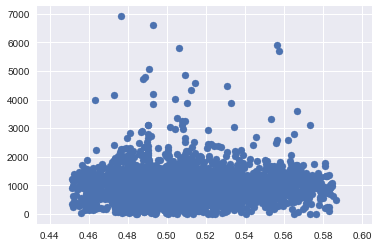

In [16]:
plt.scatter(x=dist_price_df['sum_dist'], y=dist_price_df['price'])

**=> Answer to Q3: no significant correlation between price & sum distance**

### Summary of EDA, Get Clean Data Based On Exploration

1. remove properties built in 2017
2. use `price` as the label, drop `sale_amount`
3. drop `year_built`, keep `age_year`
4. drop `sale_trans_date`
5. calculate weighted average distance all companies, and drop distances to any individual company

In [17]:
# remove properties built in 2017
df_2016 = init_df[init_df['year_built']!=2017]
df_2016.shape

(3955, 43)

In [18]:
# calcultate weighted average distance
df_2016['wei_avg_dist'] = sum_dist
df_2016.head()

,num_baths,num_beds,latitude,longitude,zip_code,property_class,sale_trans_date,sale_amount,universal_size,year_built,...,Uber,Wikimedia,Workday,Yahoo,Yelp,YouTube,Zendesk,Zoosk,Facebook,wei_avg_dist
0,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-01-04,970000,1299,1993,...,0.004867,0.000023,0.014384,0.016568,0.000515,0.012777,0.000176,0.000012,0.040131,0.511812
1,1.0,1,37.797958,-122.399894,94111,Condominium (residential),2016-01-29,1300000,1189,2007,...,0.003901,0.000030,0.013412,0.015701,0.000373,0.012242,0.000139,0.000010,0.037327,0.482447
2,2.0,0,37.803797,-122.404136,94111,Condominium (residential),2016-03-08,1475000,1423,1983,...,0.002633,0.000032,0.014539,0.016705,0.000656,0.011540,0.000150,0.000011,0.040577,0.513268
3,2.0,0,37.803797,-122.404136,94111,Condominium (residential),2016-03-21,1400000,1518,1983,...,0.001119,0.000050,0.014163,0.016370,0.000855,0.009462,0.000143,0.000011,0.039492,0.500254
4,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-03-03,955000,1033,1993,...,0.010659,0.000153,0.016205,0.018190,0.002560,0.014889,0.000621,0.000047,0.045383,0.583296


In [19]:
# drop columns
dropped_cols = list(company_names) + ['sale_amount', 'year_built', 'latitude', 'longitude',
                                     'zip_code', 'district','property_class','sale_trans_date']
clean_df = df_2016.drop(dropped_cols, axis=1)
clean_df.head()

,num_baths,num_beds,universal_size,age_year,price,duplex,apartment,condo,townhouse,num_schools,num_crimes,wei_avg_dist
0,0.0,0,1299,23,746.728253,0,0,1,0,5,21040,0.511812
1,1.0,1,1189,9,1093.355761,0,0,1,0,5,21040,0.482447
2,2.0,0,1423,33,1036.542516,0,0,1,0,5,21040,0.513268
3,2.0,0,1518,33,922.266140,0,0,1,0,5,21040,0.500254
4,0.0,0,1033,23,924.491772,0,0,1,0,5,21040,0.583296


After calculating the weighted distance from company to house, let's look at the relationship between weighted distance and price.

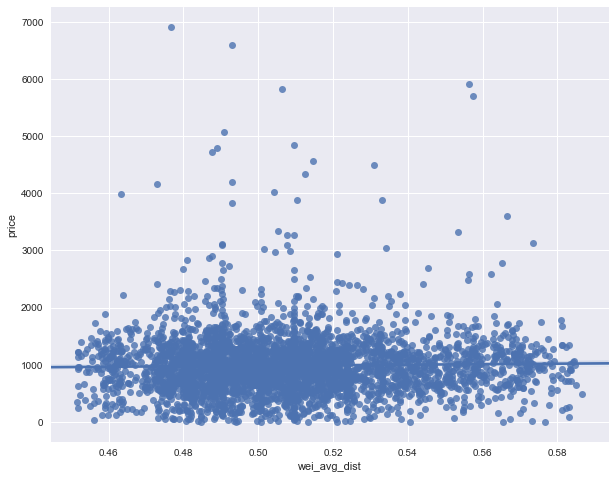

In [20]:
plt.subplots(figsize=(10, 8))  # 设置图形大小
sns.regplot(x=clean_df['wei_avg_dist'], y=clean_df['price'])  # corr()函数计算关联系数，并绘图

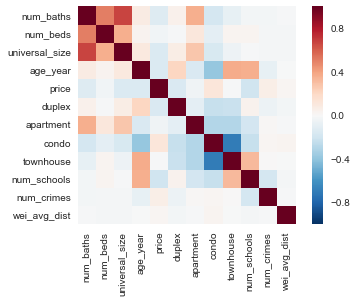

In [21]:
sns.heatmap(clean_df.corr(),square=True)

## Feature Engineering

**Use `clean_df` for the feature engineering**

Thoughts:
1. skewed numeric data -> log transformation, normalization
2. change data type -> numeric data & category data
3. Remove outliers


- Check data type

In [22]:
clean_df.dtypes

num_baths         float64
num_beds            int64
universal_size      int64
age_year            int64
price             float64
duplex              int64
apartment           int64
condo               int64
townhouse           int64
num_schools         int64
num_crimes          int64
wei_avg_dist      float64
dtype: object

In [23]:
def type_transformation(data, dtype):
    """Input:
        data (dataframe): data column that needs to be transformed
        dtype (str): target data type
    """
    for col in data.columns:
        data[col] = data[col].astype(dtype)
    return data

clean_df[['duplex','apartment','condo','townhouse']] = type_transformation(clean_df[['duplex','apartment','condo','townhouse']],'category')

In [24]:
numeric_cols = [x for x in clean_df.columns if clean_df[x].dtypes in ['float64','int64']]
numeric_cols

['num_baths',
 'num_beds',
 'universal_size',
 'age_year',
 'price',
 'num_schools',
 'num_crimes',
 'wei_avg_dist']

In [25]:
# category columns
cat_cols = ['duplex','apartment','condo','townhouse']

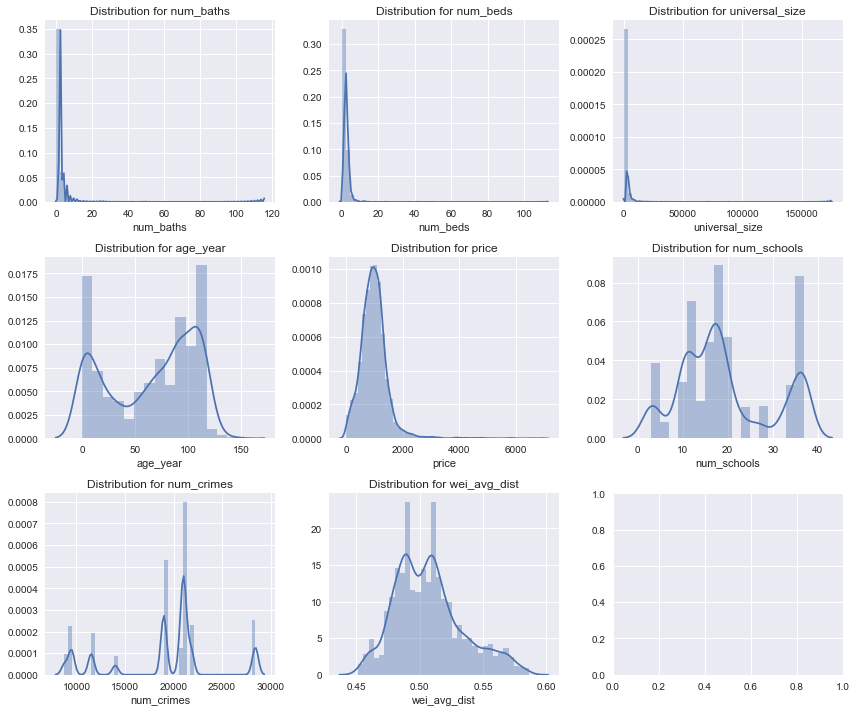

In [26]:
draw_numeric_plot(clean_df,numeric_cols,(12,10))

## Outliers

Remove outliers in `num_baths`, `num_beds` and `universal_size`. Set the `95%` quartile as our threshold

In [178]:
describe_baths = clean_df['num_baths'].describe(percentiles=[0.01,0.05,.95,.99])
describe_beds = clean_df['num_beds'].describe(percentiles=[0.01,0.05,.95,.99])
describe_size = clean_df['universal_size'].describe(percentiles=[0.01,0.05,.95,.99])

threshold_baths = describe_baths['95%']
threshold_beds = describe_beds['95%']
threshold_size = describe_size['95%']

clean_df = clean_df.loc[clean_df['num_baths'] <= threshold_baths]
clean_df = clean_df.loc[clean_df['num_beds'] <= threshold_beds]
clean_df = clean_df.loc[clean_df['universal_size'] <= threshold_size]

print("95% num_baths less than:", threshold_baths)
print("95% num_beds less than:", threshold_beds)
print("95% universal_size less than:", threshold_size)

95% num_baths less than: 0.741937344729
95% num_beds less than: 1.13140211149
95% universal_size less than: 7.37782140627


In [28]:
print('# samples: %d' % len(clean_df))

# samples: 3741


- Numeric transformation using `log` transformation or `boxcox` transformation

In [29]:
def numeric_normalization(data,method,lam=0.1):
    """
    Input:
        data (dataframe): input dataframe
        lam (float): lambda value for box-cox transformation
        methoe (str): method of numeric transformation
    Output:
        data (dataframe): return a dataframe with tranformed numeric data
    """
    if method == 'log':
        data = np.log((data+0.1)) # a trick to avoid zero value which will crash np.log()
    if method == 'boxcox':
        data = boxcox1p(data,lam)
    return data

In [30]:
clean_df[numeric_cols] = numeric_normalization(clean_df[numeric_cols], 'log')

In [31]:
# check skewness of each numeric data
print(clean_df[numeric_cols].skew())

num_baths        -2.044236
num_beds         -0.617012
universal_size    0.469326
age_year         -1.850218
price            -3.432999
num_schools      -0.965633
num_crimes       -0.982219
wei_avg_dist      0.510908
dtype: float64


- Normalize numeric data into range (0,1)

In [32]:
# def normalization(data):
#     return data/np.sum(data,axis=0)

In [33]:
clean_df.head()

,num_baths,num_beds,universal_size,age_year,price,duplex,apartment,condo,townhouse,num_schools,num_crimes,wei_avg_dist
0,-2.302585,-2.302585,7.169427,3.139833,6.615835,0,0,1,0,1.629241,9.954185,-0.491330
1,0.095310,0.095310,7.080952,2.208274,6.997098,0,0,1,0,1.629241,9.954185,-0.540516
2,0.741937,-2.302585,7.260593,3.499533,6.943742,0,0,1,0,1.629241,9.954185,-0.488953
3,0.741937,-2.302585,7.325215,3.499533,6.826942,0,0,1,0,1.629241,9.954185,-0.510403
4,-2.302585,-2.302585,6.940319,3.139833,6.829352,0,0,1,0,1.629241,9.954185,-0.380828


In [34]:
y = clean_df['price']
X = clean_df.drop(['price'],axis=1)

In [35]:
numeric_cols.remove('price')
min_max_scaler = preprocessing.MinMaxScaler()
X[numeric_cols] = min_max_scaler.fit_transform(X[numeric_cols])

In [36]:
print(X.head())

   num_baths  num_beds  universal_size  age_year duplex apartment condo  \
0   0.000000  0.000000        0.274025  0.746181      0         0     1   
1   0.609868  0.609868        0.260926  0.618460      0         0     1   
2   0.774328  0.000000        0.287522  0.795498      0         0     1   
3   0.774328  0.000000        0.297090  0.795498      0         0     1   
4   0.000000  0.000000        0.240104  0.746181      0         0     1   

  townhouse  num_schools  num_crimes  wei_avg_dist  
0         0     0.200562     0.74446      0.477821  
1         0     0.200562     0.74446      0.250663  
2         0     0.200562     0.74446      0.488797  
3         0     0.200562     0.74446      0.389737  
4         0     0.200562     0.74446      0.988156  


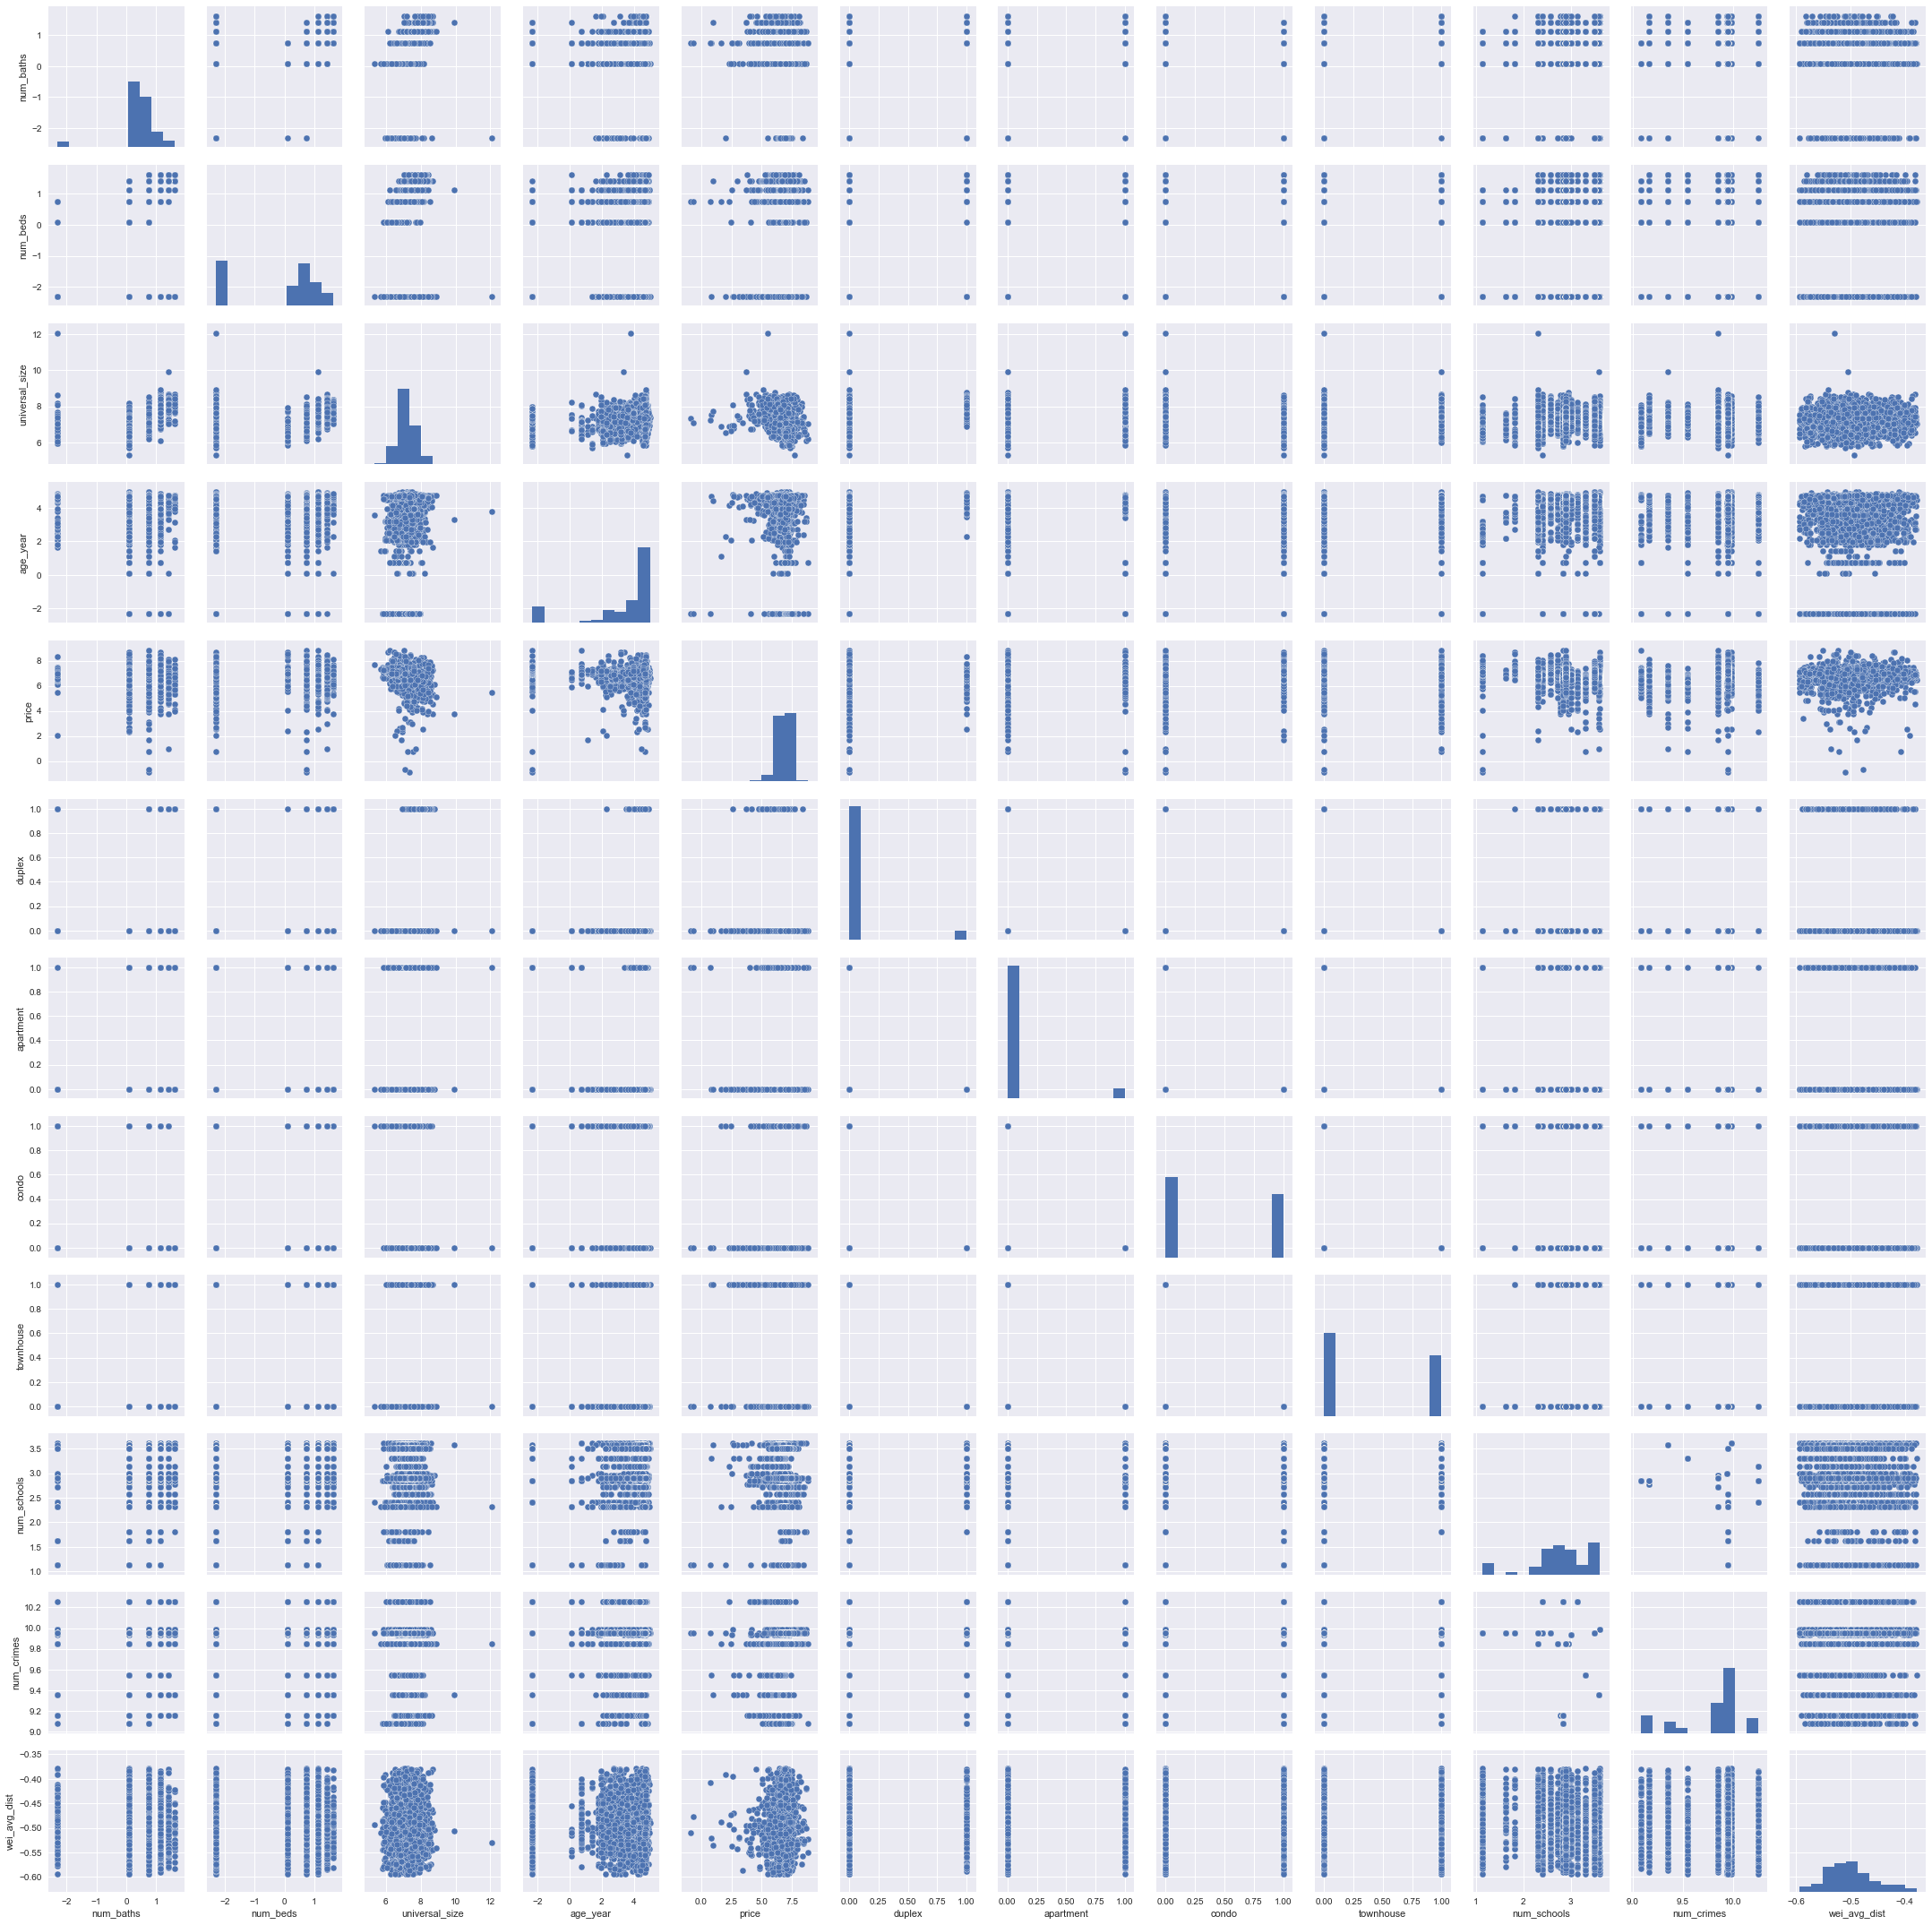

In [37]:
ax = sns.pairplot(clean_df)

In [39]:
print('Toal number of features：%d' % X.shape[1])    

Toal number of features：11


## Models

### Split data into training set and test set

In [161]:
# try to exclude some columns
X_try = X.drop('wei_avg_dist', axis=1)

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X_try, y, test_size=0.33, random_state=7)

### Baseline

In [163]:
# Calculate mean squared error on both the training and validation set
def compute_mse(model, X, y):
    """ Given a linear regression model, calculate the mean squared error for the 
        training dataset, the validation dataset, and for a mean prediction
        Args:
            model (LR_model) : Linear model
            X (array-like) : feature matrix of training data where each row corresponds to an example
            y (array like) : vector of training data outputs 
        Return: 
            MSE of linear regression on the data set    
    """
    y_pred = model.predict(X)
    train_mse = np.mean(np.power(y_pred-y,2))
    return train_mse

In [164]:
# baseline for training data
mean_y_train = y_train.mean()
train_mse_base = np.mean(np.power(mean_y_train - y_train,2))
print("baseline MSE for training data:", train_mse)

# baseline for test data
mean_y_test = y_test.mean()
test_mse_base = np.mean(np.power(mean_y_test - y_test,2))
print("baseline MSE for test data:", test_mse)

baseline MSE for training data: 0.3004961148173454
baseline MSE for test data: 0.45751252035521317


### Lasso 
**Lasso Linear Regression:**
In order to avoid overfitting, choose Linear Model trained with L1 prior as regularizer -> `lasso` linear model to run regression.   
Use `Learning Curve` to check our regression model.

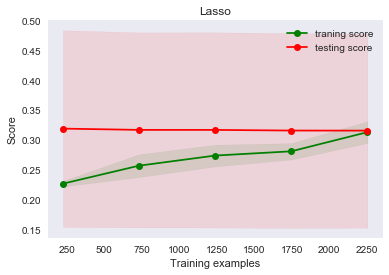

In [165]:
def plot_learning_curve(estimator, title, X, y, cv = 10, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)  
    plt.xlabel('Training examples') 
    plt.ylabel('Score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring="neg_mean_squared_error",
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(-train_scores, axis=1) 
    train_scores_std = np.std(-train_scores, axis=1) 
    test_scores_mean = np.mean(-test_scores, axis=1) 
    test_scores_std = np.std(-test_scores, axis=1) 
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1, color='g') 
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1, color='r') 
    plt.plot(train_sizes, train_scores_mean, 'o-', color='g',
             label='traning score') 
    plt.plot(train_sizes, test_scores_mean, 'o-', color='r',
             label='testing score') 
    plt.legend(loc='best')
    return plt

clf = Lasso(alpha=0.0005)
g = plot_learning_curve(clf, 'Lasso', X_train, y_train)  # 调用 plot_learning_curve 绘制学习曲线

In [166]:
clf.fit(X_train, y_train)
lasso_train_mse = compute_mse(clf, X_train, y_train)
lasso_test_mse = compute_mse(clf, X_test, y_test)
print("Lasso MSE for training data:", train_mse)
print("Lasso MSE for test data:", test_mse)

Lasso MSE for training data: 0.3004961148173454
Lasso MSE for test data: 0.45751252035521317


### Linear Regression

In [167]:
from sklearn.linear_model import LinearRegression
gs = LinearRegression()
gs.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [168]:
lr_train_mse = compute_mse(gs, X_train, y_train)
lr_test_mse = compute_mse(gs, X_test, y_test)
print("LR MSE for training data:", lr_train_mse)
print("LR MSE for test data:", lr_test_mse)

LR MSE for training data: 0.3129313920919952
LR MSE for test data: 0.4053718550829717


### RandomForest

In [169]:
from sklearn.ensemble import RandomForestRegressor
rf0 = RandomForestRegressor(n_estimators=10) #oob_score=True
rf0.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [170]:
rf0_train_mse = compute_mse(rf0, X_train, y_train)
rf0_test_mse = compute_mse(rf0, X_test, y_test)
print("RF MSE for training data:", rf0_train_mse)
print("RF MSE for test data:", rf0_test_mse)

RF MSE for training data: 0.0907112133509392
RF MSE for test data: 0.3827039109923924


In [171]:
from sklearn.model_selection import GridSearchCV
param_test1= {'n_estimators':range(5,20,5)}  
gsearch1= GridSearchCV(estimator = RandomForestRegressor(),  
                       param_grid =param_test1, cv=5)  
gsearch1.fit(X_train,y_train)  
gsearch1.grid_scores_,gsearch1.best_params_, gsearch1.best_score_  


C:\Users\me\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.01100, std: 0.13456, params: {'n_estimators': 5},
  mean: 0.10149, std: 0.07969, params: {'n_estimators': 10},
  mean: 0.14892, std: 0.07795, params: {'n_estimators': 15}],
 {'n_estimators': 15},
 0.14892321693029531)

### Polynomical

In [172]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

clf_poly = linear_model.LinearRegression()
clf_poly.fit(X_train_poly, y_train)

clf_poly_train_mse = compute_mse(clf_poly, X_train_poly, y_train)
clf_poly_test_mse = compute_mse(clf_poly, X_test_poly, y_test)
print("Poly MSE for training data:", clf_poly_train_mse)
print("Poly MSE for test data:", clf_poly_test_mse)

Poly MSE for training data: 0.27479557966698187
Poly MSE for test data: 0.3716930420547954
